Reproduce the sst anomaly seasonal maps for each WT 
 - 1 compute climatology
 - 2 break down dataset to speed up
 - 3 anomaly of WT
 - 4 plotting

In [1]:
import datetime
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import xarray as xr
import matplotlib.pyplot as plt
import glob 
import os.path
import cartopy 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


casper_2020

In [25]:
level_s = np.array([0, 1, 2.5, 5, 7.5, 10, 15, 20,25, 37.5, 50,
         75, 100, 125, 150, 200, 250, 300, 400, 500, 600, 750])

# declares a recentered projection for Pacific areas
proj = ccrs.PlateCarree(central_longitude=180)

def ax_coastlines_country(ax_s):
    ax_s.coastlines(linewidths=0.5)
    ax_s.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                           name='admin_0_countries',
                                           scale='10m',
                                           facecolor='none',
                                           edgecolor='black',
                                           linewidth=0.2))
 
def plot_prec_12(prec, min_v, max_v, n_lev, cmap_s, colorbar_ori, title_s):
    '''
    prec(12,nlat, nlon): 3d variable to plot
    colorbar_ori: colorbar orientation, verticle or horizontal
    title_s: the common title for subplot
    '''
    fig = plt.figure(figsize=(22,12))
    
    cnlevel = np.linspace(min_v, max_v, num=n_lev)
  
    for col in range(12):
        ax_s = plt.subplot(4, 3, col+1, projection=proj)
        ax_coastlines_country(ax_s)
        ax_s.add_feature(cfeature.STATES, linestyle=':')
        #ax_s.add_feature(cartopy.feature.OCEAN,zorder=100, edgecolor='k')
 
        mem = col + 1

        im=prec[col].plot.contourf(
            levels=cnlevel,
            cmap=cmap_s,
            vcenter=0,
            ax=ax_s,
            # NOTE: transform use original data center 
            transform=ccrs.PlateCarree(),
            # transform=proj,
            add_colorbar=False)
        
        im_c = prec[col].plot.contour(ax=ax_s,transform=ccrs.PlateCarree(),levels=np.linspace(min_v, max_v, num=int(n_lev/2)+1), colors='grey')
              
        gl = ax_s.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
        gl.xlines = True
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'color': 'grey', 'weight': 'bold'}
        
        plt.title('WT' + str(mem),fontweight="bold", size=15)
         
    # single title for All the Subplot
    fig.suptitle('member: ' + title_s, fontweight="bold", fontsize=30)
    
    fig.tight_layout()
    # The position of the bottom edge of the subplots, as a fraction of the figure height.
    #fig.subplots_adjust(bottom=0.15)

    #rect [left, bottom, width, height]
    #cbar_ax = fig.add_axes([0.2, 0.1, 0.7, 0.03])
    #fig.colorbar(im, cax=cbar_ax,orientation='horizontal')
    if colorbar_ori=="vertical":
        #rect [left, bottom, width, height]
        cbar_ax = fig.add_axes([0.99, 0.1, 0.04, 0.8])
    else:
        #rect [left, bottom, width, height]
        cbar_ax = fig.add_axes([0.2, 0.001, 0.7, 0.02])
    
    fig.colorbar(im, cax=cbar_ax, orientation=colorbar_ori)


In [3]:
dir_ecmwf = '/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/sst/'
dir_wt = '/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/WT_01/'

season_dict = {
    1: [12,1,2],
    2: [3,4,5],
    3: [6,7,8],
    4: [9,10,11]}
n_season = len(season_dict)

year_s = 1993
year_e = 2021

n_wt = 12

### check on data

In [4]:
flnm_test = dir_ecmwf + 'sst_199301.grib'
ds = xr.load_dataset(flnm_test, engine="cfgrib");
print('original ', flnm_test)
print(ds.dims)
 
n_mem  = ds.dims['number']
n_fcst = ds.dims['step']
n_lat  = ds.dims['latitude']
n_lon  = ds.dims['longitude'] 

latitude = ds['latitude']
longitude = ds['longitude'] 

Ignoring index file '/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/sst/sst_199301.grib.923a8.idx' older than GRIB file


original  /glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/sst/sst_199301.grib
Frozen({'number': 25, 'step': 215, 'latitude': 101, 'longitude': 360})


#### 1 climatology
 - 1.1 over all 

In [5]:
### calculate 215-day climatology of member 1-25

year_s = 1993
year_e = 2021
 
flnm_o = dir_ecmwf + 'sst_clim_215day.nc'

if os.path.isfile(flnm_o):
    print(flnm_o, 'exist')
    print('z500 mean of member 1-25 ')
    with  xr.open_dataset(flnm_o) as ds:
        z500 = ds.sst      
        print(ds.dims)
else:
    is_first = True    
    for year in range(year_s, year_e+1, 1):
        print(year)
        for month in range(1,12+1,1):
            mon_s = str(month).zfill(2)
             
            flnm = dir_ecmwf + 'sst_' + str(year) + mon_s + '.grib' 
            print(flnm)
            ds = xr.load_dataset(flnm, engine="cfgrib")
            # read 1-25 members , member 26-51 starts 2017 
            z500 = ds.sst[:25].squeeze(drop=True).mean(dim=['number','step']) 
            if is_first == True:
                data_all = z500 
                is_first = False
            else:
                data_all = xr.concat([data_all, z500], dim='step')
                                         
    print(data_all.shape)
    z500_mean = data_all.mean(dim='step')
    z500_mean = z500_mean.rename('sst')  
     
    print(flnm_o) 
    z500_mean.to_netcdf(path = flnm_o)  

/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/sst/sst_clim_215day.nc exist
z500 mean of member 1-25 
Frozen({'latitude': 101, 'longitude': 360})


 - 1.2 seasnal climatology

In [6]:
flnm_o = dir_ecmwf + 'sst_seasonal_cli.nc'

z500_3d = np.zeros((n_season, n_lat, n_lon))
ct_1d = np.zeros((n_season))

if os.path.isfile(flnm_o):
    print(flnm_o, 'exist')
    print('sst seasonal mean of member 1-25 ')
    with  xr.open_dataset(flnm_o) as ds:
        z500_xr = ds.__xarray_dataarray_variable__     #(4, 101,360)
        print(ds.dims)
else: 
    for year in range(year_s, year_e+1, 1):
        for month in range(1,13,1):
            mon_s = str(month).zfill(2)
            flnm = dir_ecmwf + 'sst_' + str(year) + mon_s + '.grib' 
            print(flnm)
            ds = xr.load_dataset(flnm, engine="cfgrib")
                    
            StartDay = datetime.datetime(year, month, 1,  0)
            # fcst = 215 day 7 months
            EndDay = pd.to_datetime(StartDay, format="%Y%m") + MonthEnd(7)
            TimeDD = pd.date_range(StartDay, EndDay, freq='d')            
            
            for key in season_dict:
                for mon_season in season_dict[key]:
                    #print('season:',key, 'month:',mon_season)
                    
                    ind_m = np.where(TimeDD.month == mon_season)[0]
                    if len(ind_m) != 0:
                        # read 1-25 members , member 26-51 starts 2017 
                        z500_all = ds.sst[:25] 
                        z500 = z500_all[:, ind_m].mean(dim=['number','step'])
                        z500_3d[key-1] = z500_3d[key-1] + z500
                        ct_1d[key-1] = ct_1d[key-1] + 1
    
    for ns in range(n_season):
        z500_3d[ns] = z500_3d[ns]/ct_1d[ns]
        
    print('output:', flnm_o)
    z500_xr = xr.DataArray(z500_3d, 
                coords={'latitude': latitude, 'longitude':longitude, 'season':range(n_season)},
                dims=["season", "latitude", "longitude"])
        
    z500_xr.to_netcdf(path = flnm_o)          

/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/sst/sst_seasonal_cli.nc exist
sst seasonal mean of member 1-25 
Frozen({'latitude': 101, 'longitude': 360, 'season': 4})


#### 2 break 1-51 member data to each member
(to speed up process)

In [7]:
year_s = 1993
year_e = 2021

#year_s = 2017

for year in range(year_s, year_e+1, 1):
    #print(year)
    for month in range(1,12+1,1):
        mon_s = str(month).zfill(2)
        flnm_i = dir_ecmwf + 'sst_' + str(year) + mon_s + '.grib' 
        # print(flnm_i)
        flnm_o = dir_ecmwf + 'sst_' + str(year) + mon_s + '_mem01.nc' 
        #if os.path.isfile(flnm_o):
        #    print(flnm_o, ' - member 25 (-2016) or 51 (2017-) exist')
        if not os.path.isfile(flnm_o):
            if year < 2017:
                n_mem = 25
            else:
                n_mem = 51
        
            ds = xr.load_dataset(flnm_i, engine="cfgrib") 
        
            z500 = ds.sst
            
            for mem  in range(1, n_mem+1, 1):  
                mem_s = str(mem).zfill(2)
                flnm_o = dir_ecmwf + 'sst_' + str(year) + mon_s + '_mem' + mem_s +'.nc' 
                #print(flnm_o)
                z500_12Z = z500[mem-1,:,:,:]
                z500_12Z = z500_12Z.rename('sst')
                z500_12Z = z500_12Z.rename({'step':'forecast_time'})
                z500_12Z.to_netcdf(path = flnm_o)
print('finished')                 

finished


#### 3 z500 anomalies of WTs
 - 3.1 annual

In [8]:
# Climatology of ensemble anomaly is slow, 
# so I calculated member by member  
# James and I decided to use anamaly calculation use climatology of member mean

year_s = 1993
year_e = 2021
#year_e = year_s

n_wt = 12
n_fcst = 215
n_mem = 51

with  xr.open_dataset(dir_ecmwf + 'sst_clim_215day.nc') as ds_prec:
    z500_cli = ds_prec.sst
     
z500_3d = np.zeros((n_wt, z500_cli.shape[0], z500_cli.shape[1]))

for mem in range(1, n_mem+1, 1): 
    mem_s = str(mem).zfill(2) 
    flnm_o = dir_wt + 'sst_ano_mem' + mem_s +'.nc'

    #if os.path.isfile(flnm_o):
    #    print(flnm_o, 'exist')
    if not os.path.isfile(flnm_o):
        for nw in range(n_wt):
            print('mem', mem, nw+1)
            is_first = True
            if mem < 26:
                year_s = 1993
            else:
                year_s = 2017
            
            for year in range(year_s, year_e+1, 1):   
                for month in range(1, 13, 1):
                    month_s = str(month).zfill(2)

                    # read WT file
                    flnm_wt = dir_wt + 'CONUS-WTs_' + str(year) + month_s + '_'+ mem_s +'.cla'               
                    wts = pd.read_csv(flnm_wt, delimiter = '\t', header=None,  names=["year", "month", "day", "wt"])
           
                    if nw+1 in wts.wt.unique(): 
                        wts_g = wts.groupby(['wt'])
                        flnm = dir_ecmwf + 'sst_' + str(year) + month_s + '_mem' + mem_s + '.nc'  
                        
                        with  xr.open_dataset(flnm) as ds:
                            z500 = ds.sst
                            g_ind = wts_g.get_group(nw+1).index     
                         
                            z500_wt = z500[g_ind,:,:]                     
                   
                            if is_first == True:
                                data_all = z500_wt.copy()
                                is_first = False
                            else:
                                data_all = xr.concat([data_all, z500_wt.copy()], dim='forecast_time')                                
               
            z500_3d[nw] = (data_all.mean("forecast_time") - z500_cli)/z500_cli  
     
        z500_xr = xr.DataArray(z500_3d, 
                coords={'latitude': z500_cli.latitude, 'longitude': z500_cli.longitude, 'wt':range(n_wt)},
                dims=["wt", "latitude", "longitude"])
        print(flnm_o)
        z500_xr.to_netcdf(path = flnm_o)  
print('succeed')

succeed


 - 3.2 seasonal anomaly

In [9]:
with  xr.open_dataset(dir_ecmwf + 'sst_seasonal_cli.nc') as ds_prec:
    z500_cli = ds_prec.__xarray_dataarray_variable__

for mem in range(1, n_mem+1, 1): 
    # throw out the small number of weather types
    if mem <26:
        n_nan = 50
    else:
        n_nan = 10
        
    z500_4d = np.zeros((n_wt, n_season, n_lat, n_lon))   # (12, 4, 101, 360)
    ct_2d = np.zeros((n_wt, n_season))
    
    mem_s = str(mem).zfill(2) 
    flnm_o = dir_wt + 'sst_seasonal_ano_mem' + mem_s + '.nc'
     
    if not os.path.isfile(flnm_o):
        if mem < 26:
            year_s = 1993
        else:
            year_s = 2017
            
        for year in range(year_s, year_e+1, 1):  
            print(year)
            
            for month in range(1,13,1):
                month_s = str(month).zfill(2)
                StartDay = datetime.datetime(year, month, 1,  0)
                # fcst = 215 day 7 months
                EndDay = pd.to_datetime(StartDay, format="%Y%m") + MonthEnd(7)
                TimeDD = pd.date_range(StartDay, EndDay, freq='d') 
                
                # read WT file
                flnm_wt = dir_wt + 'CONUS-WTs_' + str(year) + month_s + '_'+ mem_s +'.cla'               
                wts = pd.read_csv(flnm_wt, delimiter = '\t', header=None,  names=["year", "month", "day", "wt"])
                #print(flnm_wt)      
                wts_g = wts.groupby(['wt','month'])
                
                flnm = dir_ecmwf + 'sst_' + str(year) + month_s + '_mem' + mem_s + '.nc'  
                #print(flnm)
                with  xr.open_dataset(flnm) as ds:
                    z500 = ds.sst
                
                for key in season_dict:
                    for mon_season in season_dict[key]:
                        for wt in range(1, n_wt+1):
                            try:
                                #print(wts_g.get_group((wt, mon_season)).index)
                                ind_g = wts_g.get_group((wt, mon_season)).index
                                z500_4d[wt-1, key-1,:,:] = z500_4d[wt-1, key-1,:,:] + z500[ind_g,:,:].sum(dim='forecast_time')
                                ct_2d[wt-1, key-1] = ct_2d[wt-1, key-1] + len(ind_g)
                            except:
                                #print('no', wt, mon_season)
                                continue 
                                
        for ns in range(n_season):
            for nw in range(n_wt):
                if ct_2d[nw, ns] < n_nan:
                    z500_4d[nw,ns] = 0
                    ct_2d[nw, ns] = 0
                else:
                    z500_4d[nw,ns] = z500_4d[nw, ns]/ct_2d[nw, ns]
                    z500_4d[nw,ns] = (z500_4d[nw, ns] - z500_cli[ns])/z500_cli[ns]
        
        z500_xr = xr.DataArray(z500_4d, 
                coords={'latitude': latitude.values, 'longitude': longitude.values, \
                        'wt':range(n_wt), 'season':range(n_season)},
                dims=["wt", "season", "latitude", "longitude"])
        z500_xr.to_netcdf(path = flnm_o)  
        print(flnm_o)
print('finished')

finished


#### Plotting

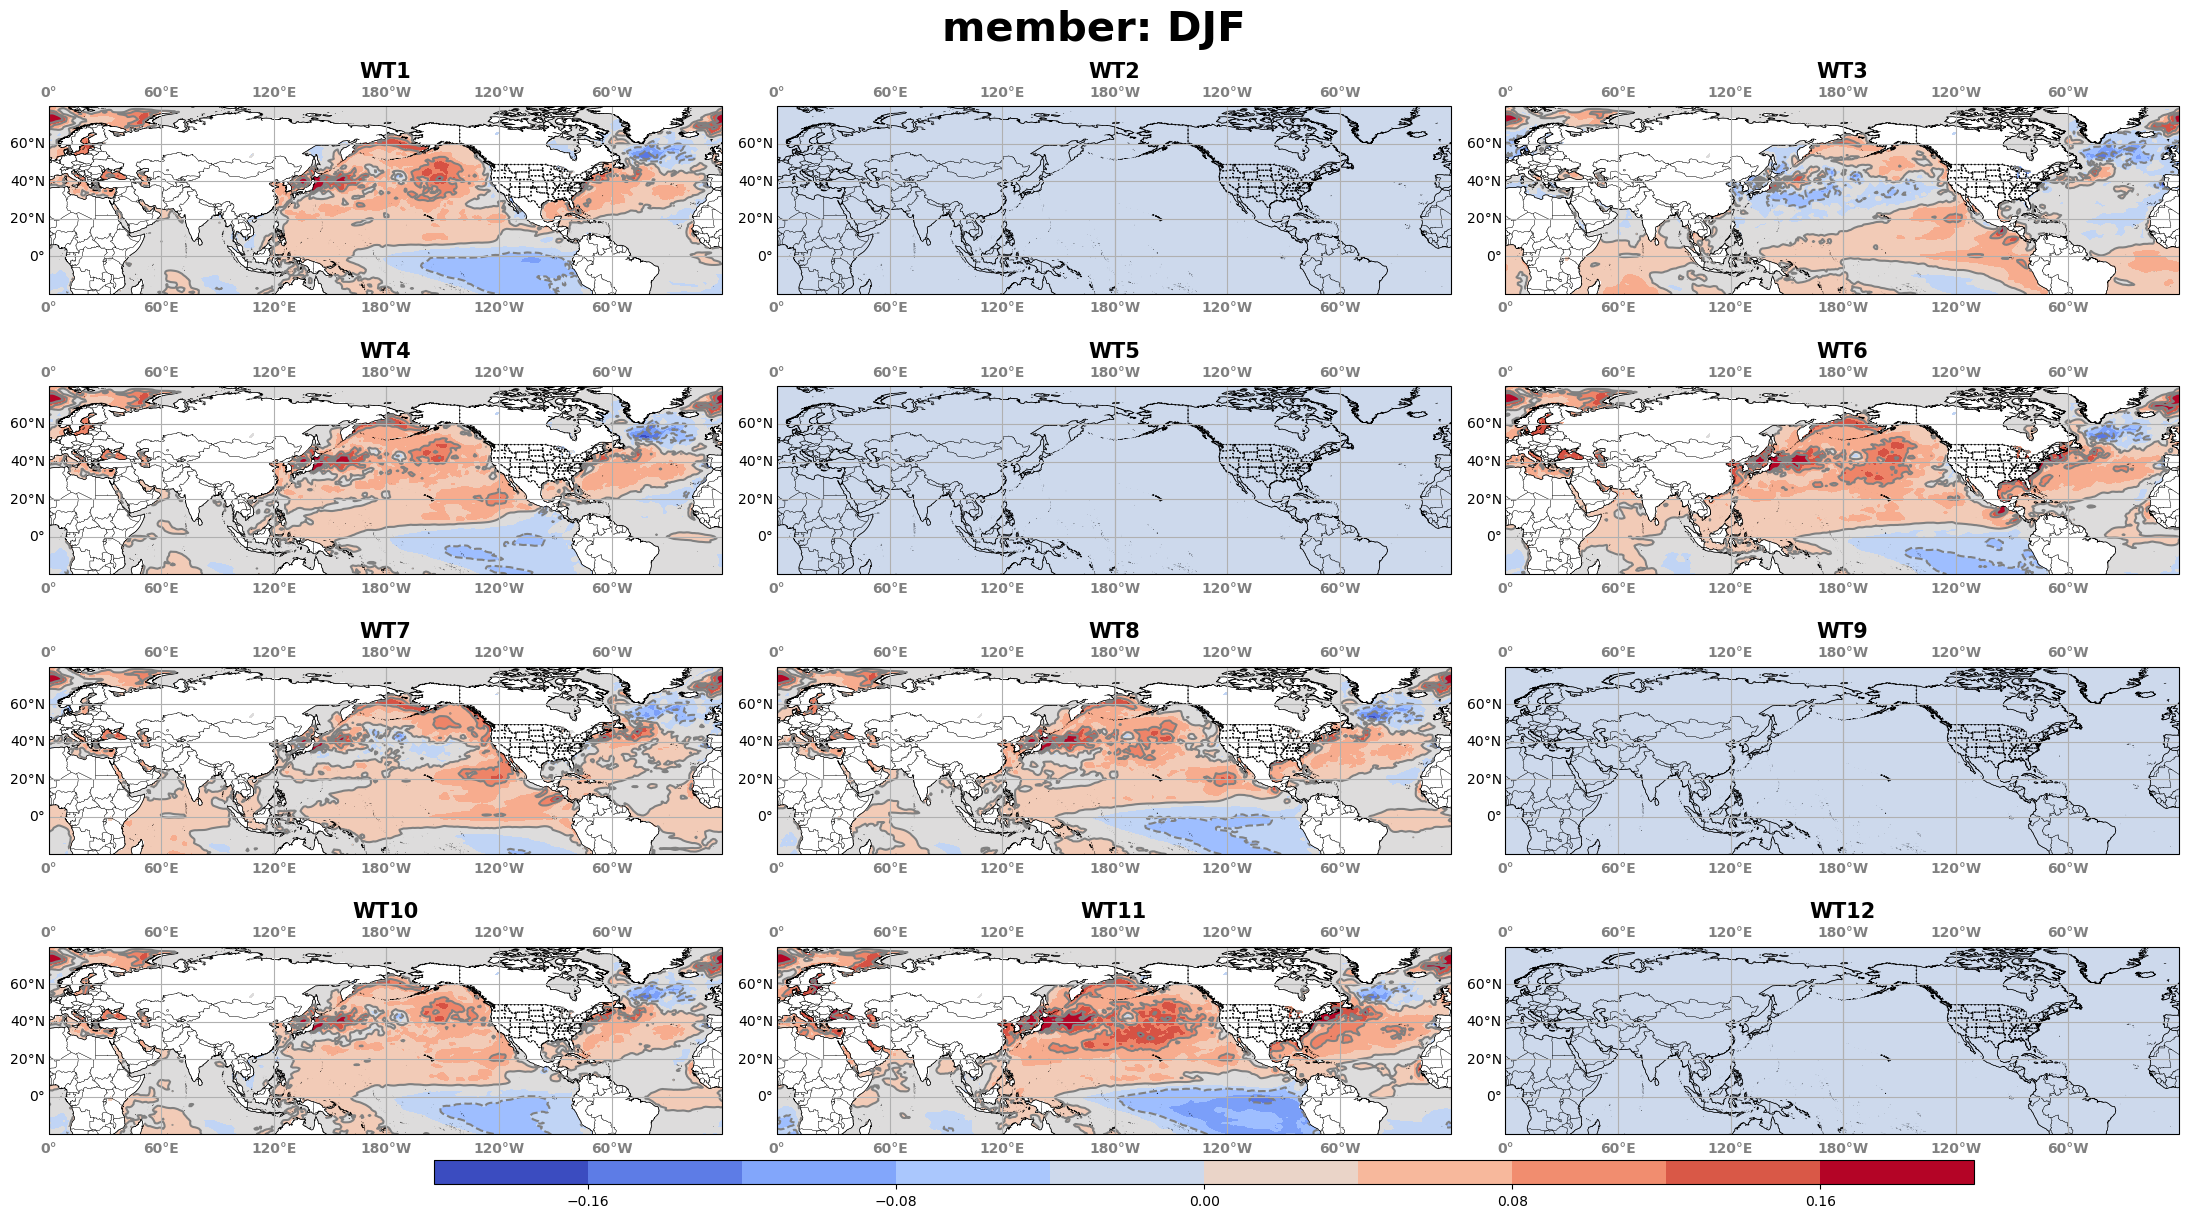

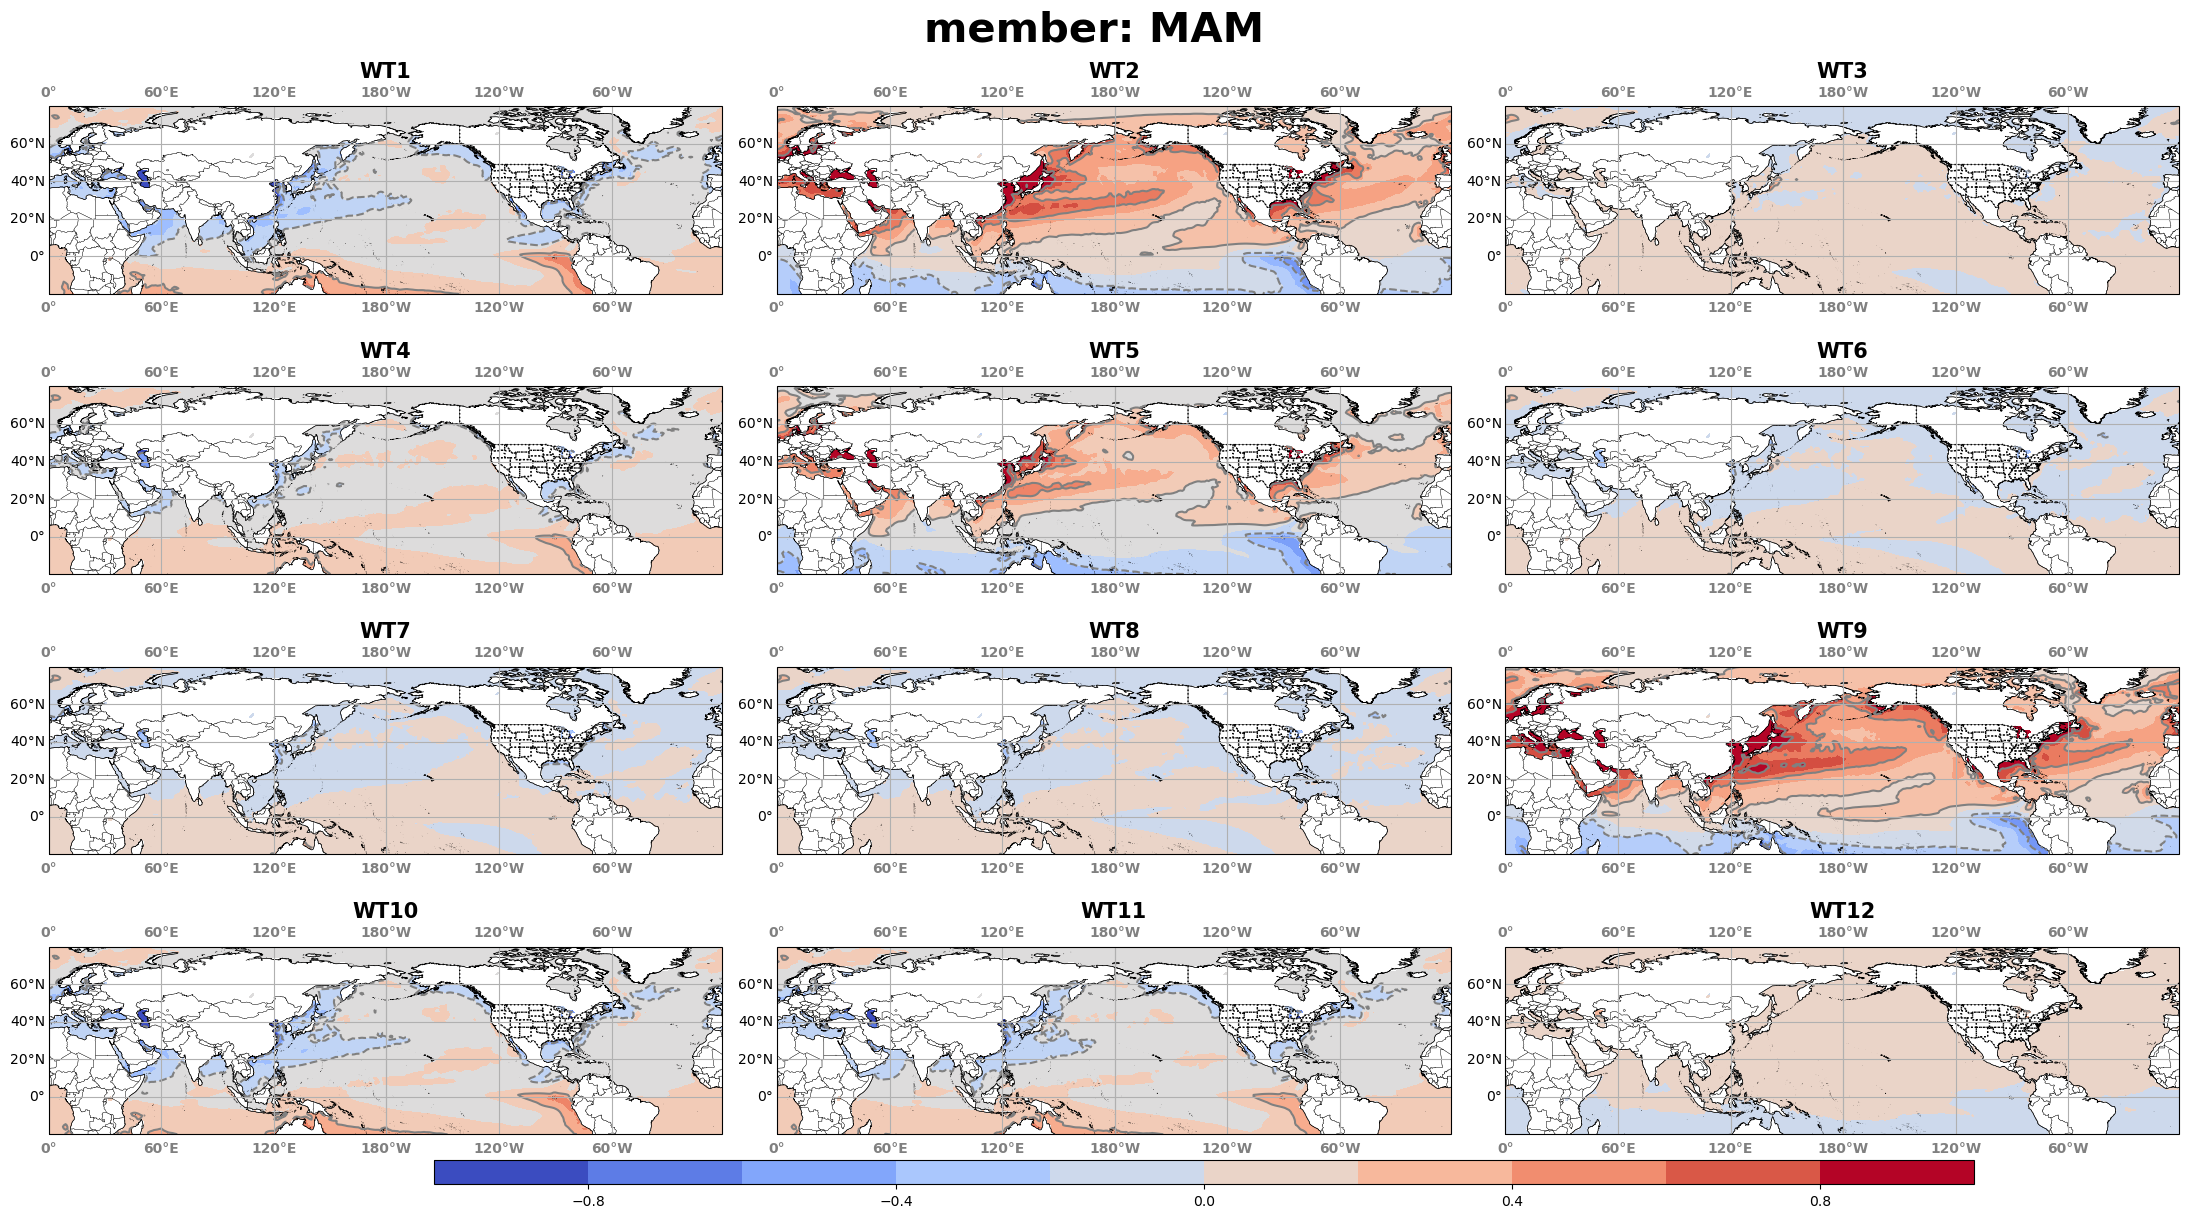

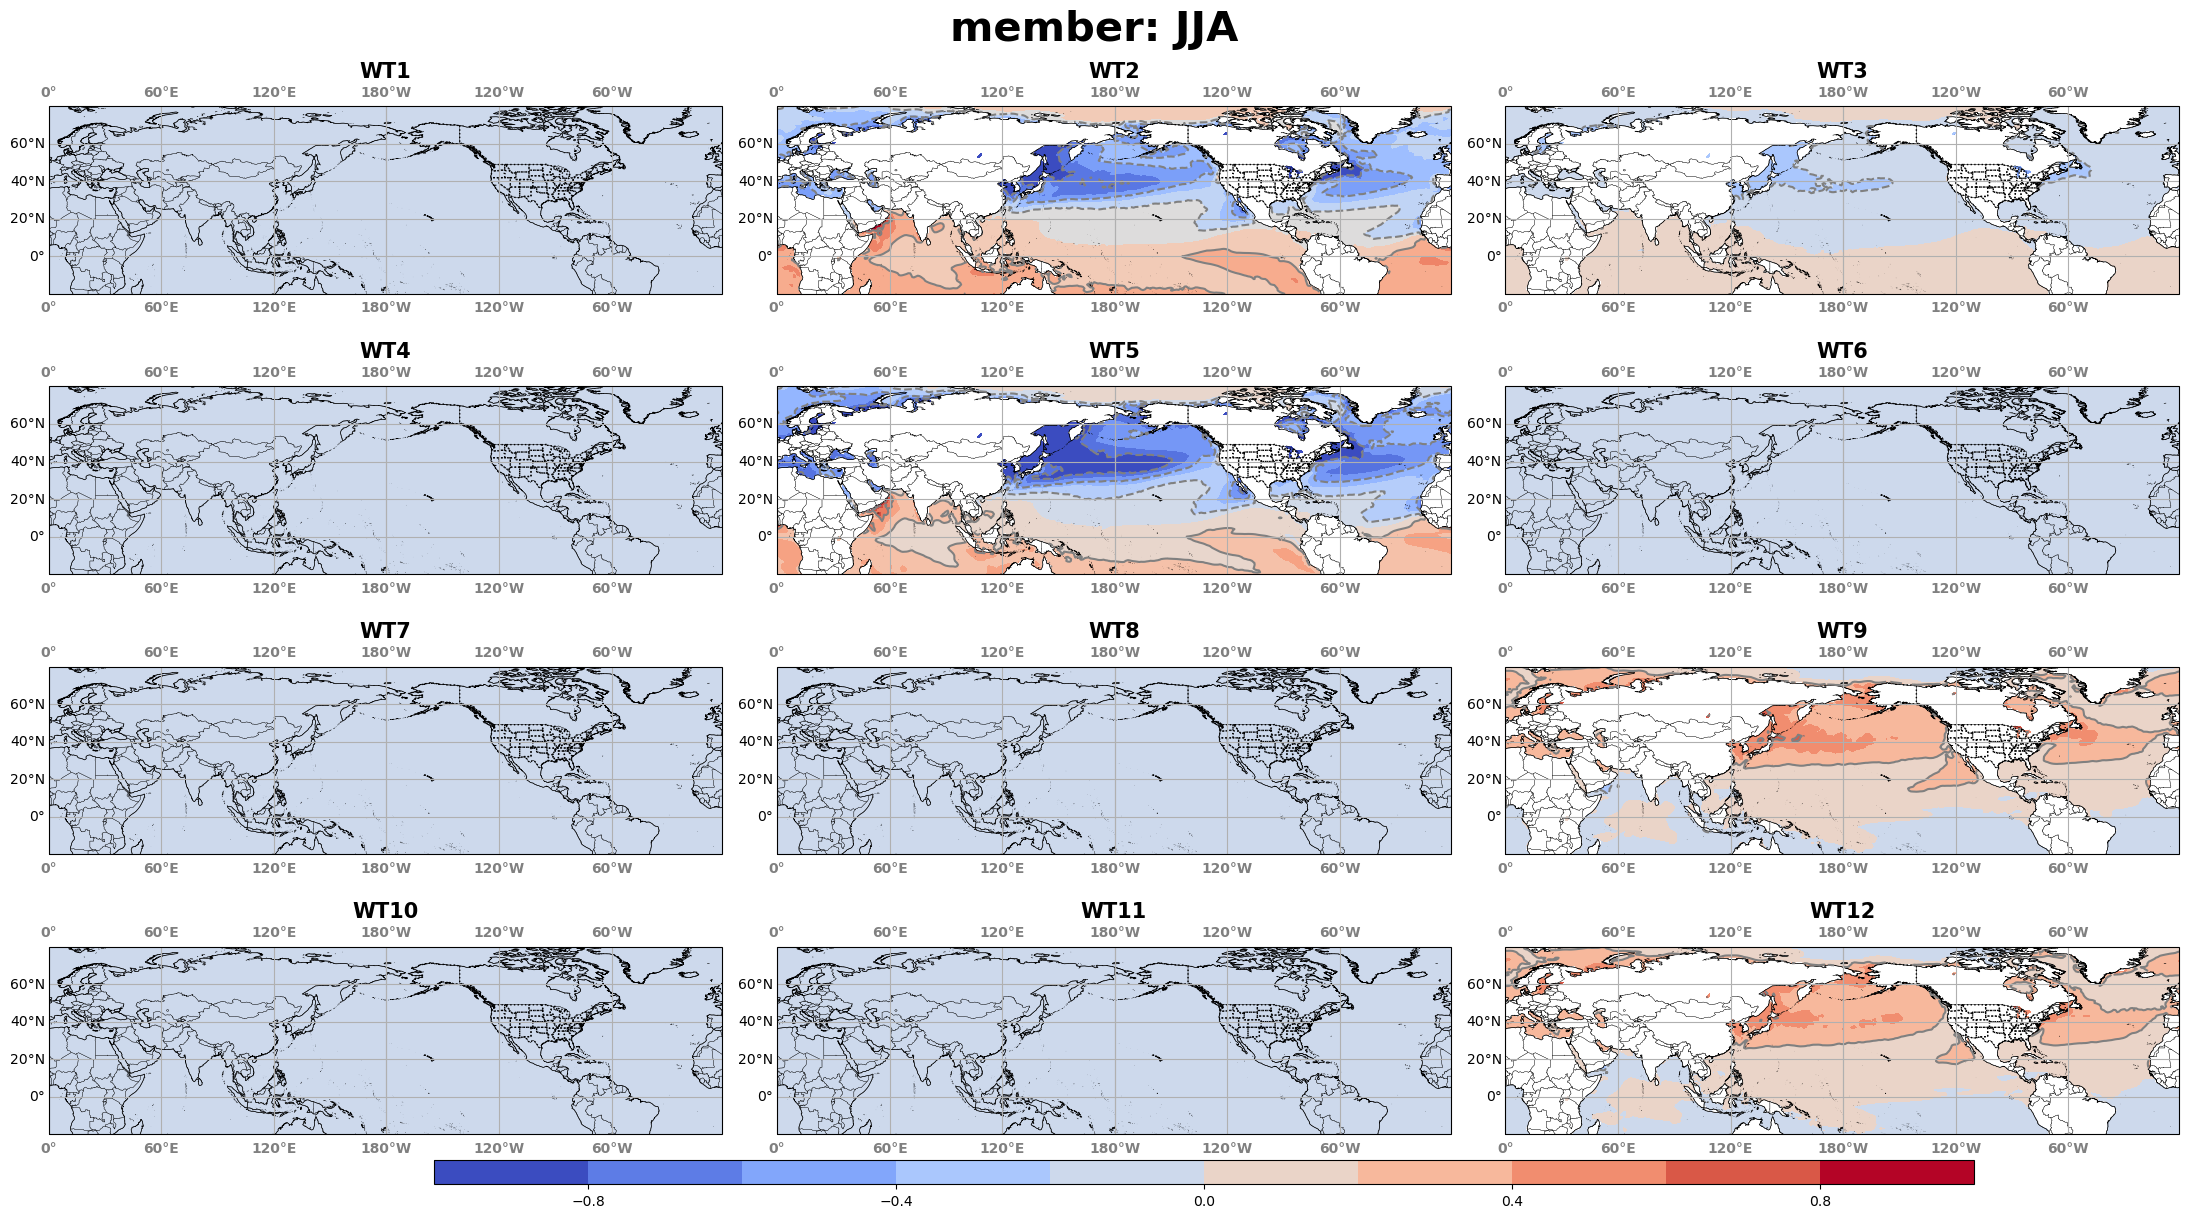

In [ ]:
for mem in range(1,52):
    mem_s = str(mem).zfill(2) 
    flnm = dir_wt + 'sst_seasonal_ano_mem' + mem_s + '.nc'
    mem_s = str(mem).zfill(2) 
    with  xr.open_dataset(flnm) as ds:
        if mem == 1: 
            z500_wt = ds.__xarray_dataarray_variable__.copy()
        else:
            z500_wt = z500_wt + ds.__xarray_dataarray_variable__

season_s = ['DJF','MAM','JJA','SON']            

# Because proj = ccrs.PlateCarree(central_longitude=180)
# I need to convert longitude from [-180, 180] -> [0,360]  to avoid a line in the middle
z500_wt.coords['longitude'] = xr.where(z500_wt['longitude'] < 0, z500_wt['longitude'] + 360, z500_wt['longitude'])
z500_wt = z500_wt.sortby(z500_wt.longitude)

for ns in range(n_season):    
    if ns != 0:
        plot_prec_12(z500_wt[:,ns]/51*100, -1., 1., 11, 'coolwarm', 'horizontal', season_s[ns]);
    else:
        plot_prec_12(z500_wt[:,ns]/51*100, -0.2, 0.2, 11, 'coolwarm', 'horizontal', season_s[ns]); 

#### ensemble average z500 anomaly maps for each WT

https://www.frontiersin.org/articles/10.3389/fenvs.2019.00036/full

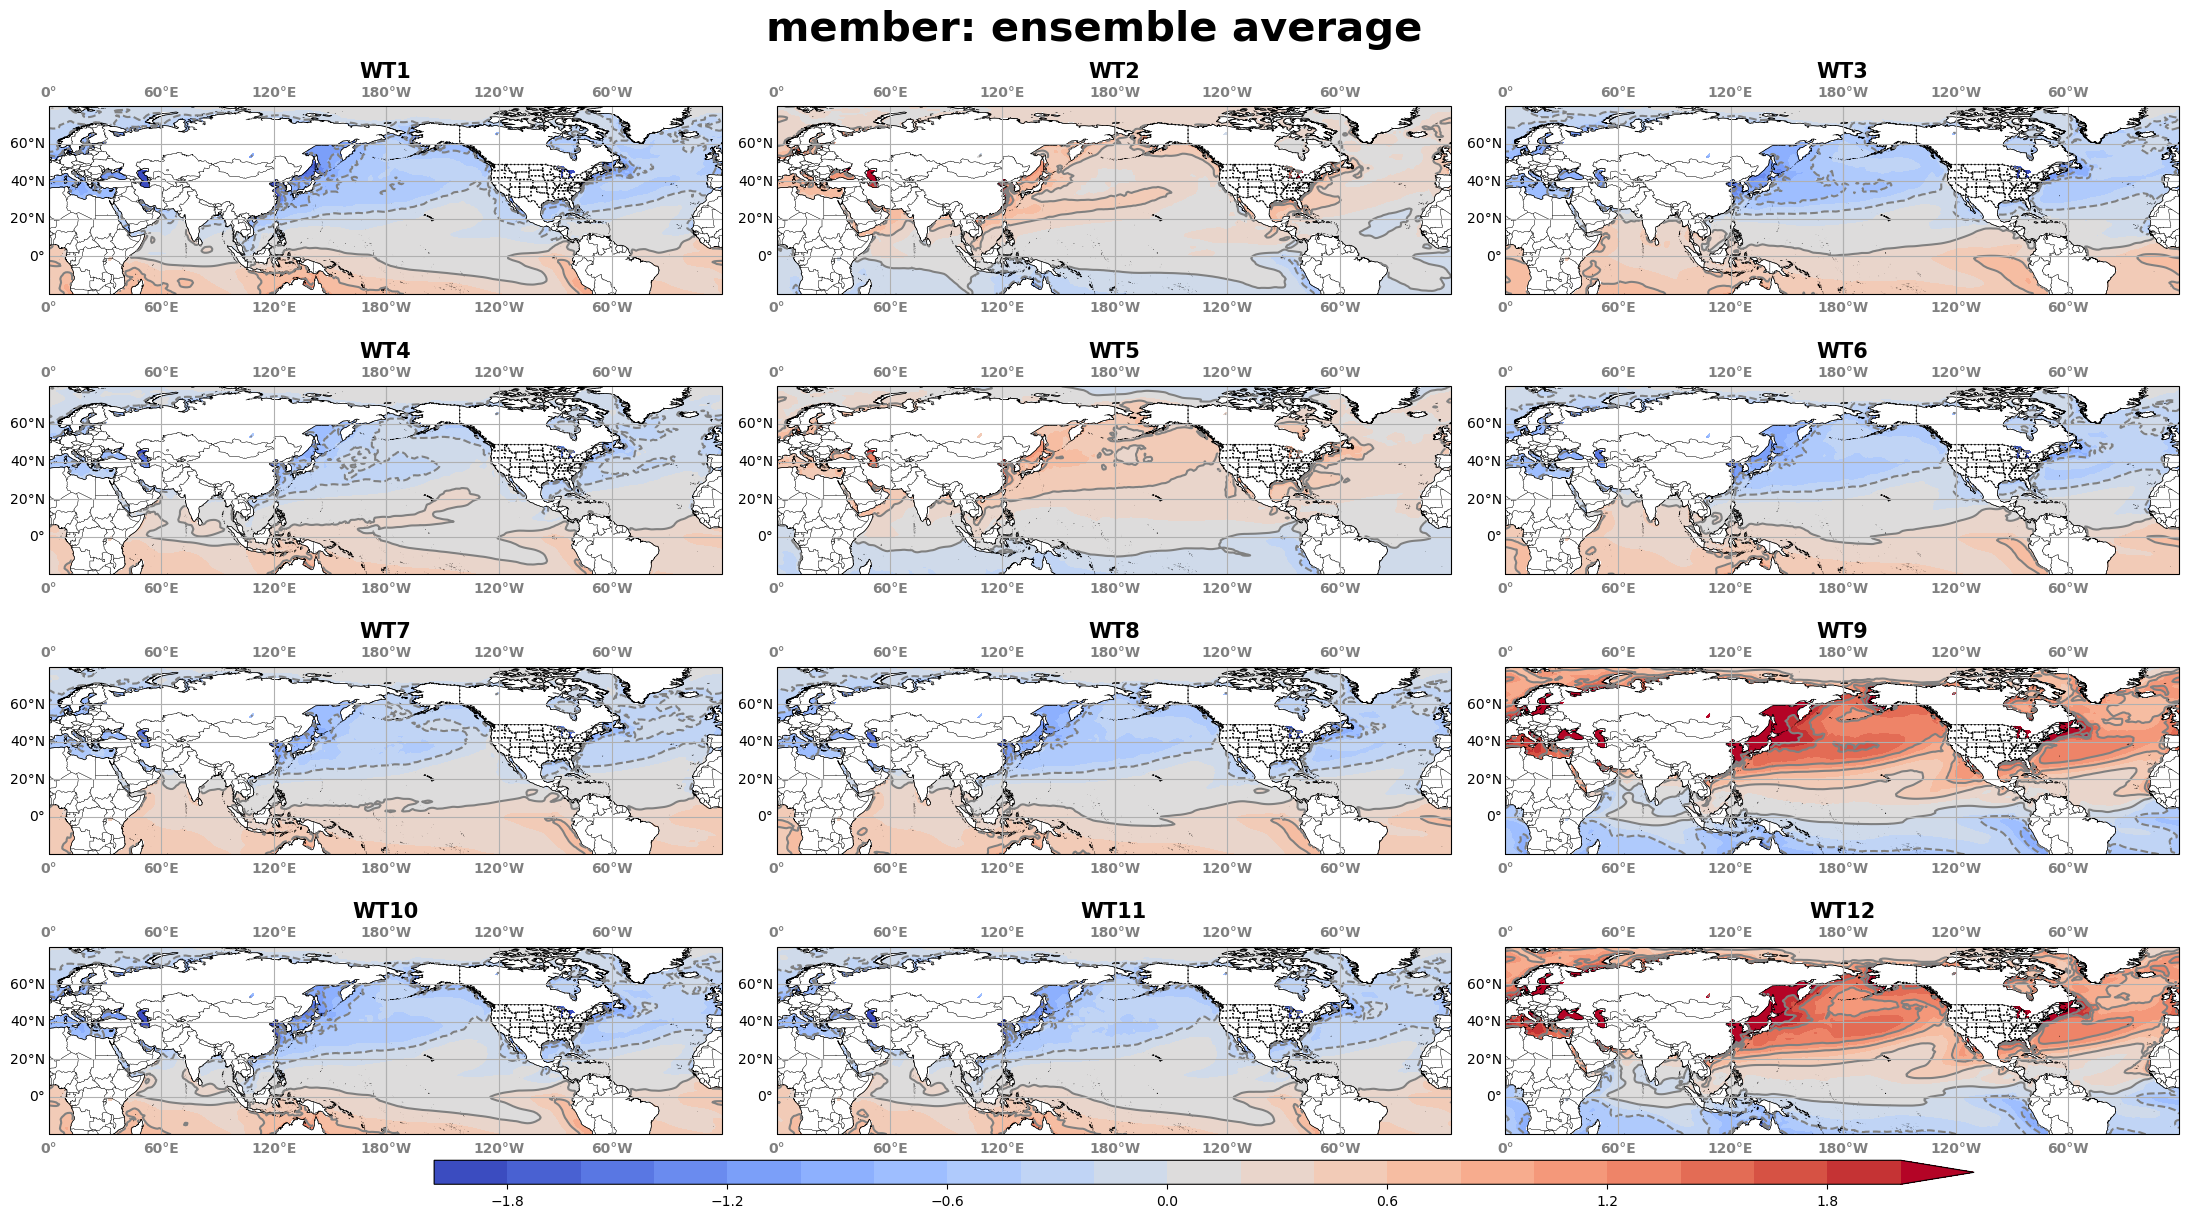

In [26]:
for mem in range(1, n_mem+1,1):
    mem_s = str(mem).zfill(2)
    flnm_wt = dir_wt + 'sst_ano_mem' + mem_s + '.nc'
    #print(flnm_wt)
    
    with  xr.open_dataset(flnm_wt) as ds:
        z500_wt = ds.__xarray_dataarray_variable__
        if mem == 1:
            z500_avg = z500_wt.copy()
        else:
            z500_avg = z500_avg + z500_wt

# Because proj = ccrs.PlateCarree(central_longitude=180)
# I need to convert longitude from [-180, 180] -> [0,360]  to avoid a line in the middle
z500_avg.coords['longitude'] = xr.where(z500_avg['longitude'] < 0, z500_avg['longitude'] + 360, z500_avg['longitude'])
z500_avg = z500_avg.sortby(z500_avg.longitude)

plot_prec_12(z500_avg*100/n_mem, -2., 2., 21, 'coolwarm', 'horizontal', 'ensemble average')